# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. На основе данных о поведении клиентов необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Для решения данной задачи построим предсказательную модель. Критерием, по которому будет отбираться лучшая модель, будет *F1*-мера, так же необходимо проверить метрику *AUC-ROC* и максимизировать полноту

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score 
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## Подготовка данных

### Заполнение пропусков

In [2]:
data = pd.read_csv("datasets/Churn.csv")
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Пропуски есть в столбце `Tenure`, посмотрим на него поближе

In [3]:
data["Tenure"].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [4]:
data.dropna(inplace=True)

### Удаление незначимых признаков

Если посмотреть на таблицу, можно заметить, что в ней есть лишние столбцы, на них не должна обращать внимание наша модель. Это столбцы - `RowNumber`, `CostomerID` и `Surname`

In [5]:
data_new = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

### Кодирование OHE

В датафрейме остались не численные признаки, небходимо применить прямое кодирование

In [6]:
df = pd.get_dummies(data_new, drop_first=True)

### Разделение датасета на выборки

Тестовой выборки нет, поэтому разделим исходный датафрейм на три выборки - обучающую, тестовую и валидационную

In [7]:
features = df.drop("Exited", axis=1)
target = df["Exited"]

features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = \
train_test_split(features_test, target_test, test_size=0.5, random_state=12345)

print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(5454,)
(1819,)
(1818,)


### Масштабирование признаков

Признаки в нашей задаче имеют разную размерность, поэтому их необходимо масштабировать

In [8]:
pd.options.mode.chained_assignment = None

features_train = pd.DataFrame(features_train, columns = features.columns)
features_valid = pd.DataFrame(features_valid, columns = features.columns)
features_test = pd.DataFrame(features_test, columns = features.columns)
scaler = StandardScaler()
numeric = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

### Оценка дисбаланса

Рассмотрим дисбаланс в обучающей выборке

In [9]:
target_train.sum()/target_train.count()

0.20645397873120647

20% - не то что бы мало, но до 50 ещё далеко

### Обучение моделей без учёта дисбаланса

#### Решающее дерево

In [10]:
%%time

grid_for_tree = {"max_depth": [i for i in range(2, 20)],
           "max_features": ["sqrt", "auto", None],
           'min_samples_leaf': [1, 2, 3, 4, 5, 6],
           'min_samples_split': [2, 3, 4, 5, 6]}
model_grid_for_tree = RandomizedSearchCV(
    DecisionTreeClassifier(), param_distributions = grid_for_tree, scoring="f1", n_iter = 150, random_state=12345)
model_tree = model_grid_for_tree.fit(features_train, target_train)

Wall time: 9.11 s


In [11]:
print("Наилучшие параметры:", model_tree.best_params_)
print("f1-мера на тренировочной выборке:", f1_score(target_train, model_tree.predict(features_train)))
print("f1-мера на кросс-валидации (?):", model_tree.best_score_)
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_tree.predict(features_valid)))

Наилучшие параметры: {'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 8}
f1-мера на тренировочной выборке: 0.6574320724560468
f1-мера на кросс-валидации (?): 0.5512955793859391
f1-мера на валидационной выборке: 0.5060658578856153


####  Случайный лес

In [12]:
%%time

grid_for_forest = {"max_depth": [i for i in range(2, 20)],
           "n_estimators": [i for i in range(50, 100, 5)],
           "max_features": ["log2", "sqrt", None],
           'min_samples_leaf': [1,2,3,4,5,6],
           'min_samples_split': [2,3,4,5,6]}
model_grid_for_forest = RandomizedSearchCV(
    RandomForestClassifier(), param_distributions = grid_for_forest, scoring="f1", n_iter = 25, random_state=12345)
model_forest = model_grid_for_forest.fit(features_train, target_train)

Wall time: 1min


In [13]:
print("Наилучшие параметры:", model_forest.best_params_)
print("f1-мера на тренировочной выборке:", f1_score(target_train, model_forest.predict(features_train)))
print("f1-мера на кросс-валидации (?):", model_forest.best_score_)
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_forest.predict(features_valid)))

Наилучшие параметры: {'n_estimators': 75, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 18}
f1-мера на тренировочной выборке: 0.8614487117160915
f1-мера на кросс-валидации (?): 0.5832293676639995
f1-мера на валидационной выборке: 0.5856905158069884


#### Логистическая регрессия

In [14]:
%%time

grid_for_logistic = {"solver": ["lbfgs", "liblinear"],
           "max_iter": [i for i in range(100, 200, 10)]}
model_grid_for_logistic = GridSearchCV(
    LogisticRegression(), param_grid = grid_for_logistic, scoring="f1")
model_logistic = model_grid_for_logistic.fit(features_train, target_train)

Wall time: 5.69 s


In [15]:
print("Наилучшие параметры:", model_logistic.best_params_)
print("f1-мера на тренировочной выборке:", f1_score(target_train, model_logistic.predict(features_train)))
print("f1-мера на кросс-валидации (?):", model_logistic.best_score_)
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_logistic.predict(features_valid)))

Наилучшие параметры: {'max_iter': 100, 'solver': 'liblinear'}
f1-мера на тренировочной выборке: 0.2962962962962963
f1-мера на кросс-валидации (?): 0.2972917814099498
f1-мера на валидационной выборке: 0.3175965665236052


### Вывод
В целевом признаке положительного класса в 4 раза меньше, чем отрицательного. По итогам построения моделей без избавления от дисбаланса, лучший результат показала модель случайного леса, но отбрасывать остальные модели не будем, посмотрим, как они себя покажут, если сбалансировать целевой признак

## Борьба с дисбалансом

В предыдущем разделе неплохо показали себя решающее дерево и случаный лес, поэтому попробуем учучшить их качество

### С помощью взвешивания классов

Создадим модели с лучшими параметрами, полученными в предыдущей части

#### Решающее дерево

In [16]:
model_tree_b = DecisionTreeClassifier(
    max_depth = 9, min_samples_split = 6, min_samples_leaf = 1, max_features = None, class_weight = "balanced")

model_tree_b.fit(features_train, target_train)

print("f1-мера на тренировочной выборке:", f1_score(target_train, model_tree_b.predict(features_train)))
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_tree_b.predict(features_valid)))

f1-мера на тренировочной выборке: 0.6964155084125823
f1-мера на валидационной выборке: 0.5252525252525252


#### Случайный лес

In [17]:
model_forest_b = RandomForestClassifier(
    n_estimators=95, min_samples_split=5, min_samples_leaf=6, max_features=None, max_depth=14, class_weight="balanced", random_state=12345)

model_forest_b.fit(features_train, target_train)

print("f1-мера на тренировочной выборке:", f1_score(target_train, model_forest_b.predict(features_train)))
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_forest_b.predict(features_valid)))

f1-мера на тренировочной выборке: 0.8320000000000001
f1-мера на валидационной выборке: 0.6086956521739131


#### Логистическая регрессия

In [18]:
model_logistic_b = LogisticRegression(class_weight = "balanced")

model_logistic_b.fit(features_train, target_train)

print("f1-мера на тренировочной выборке:", f1_score(target_train, model_logistic_b.predict(features_train)))
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_logistic_b.predict(features_valid)))

f1-мера на тренировочной выборке: 0.4927907721884012
f1-мера на валидационной выборке: 0.5025432349949135


### Upsampling

Расширим класс, который в дефиците

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * 4)
    
    return shuffle(features_upsampled, target_upsampled, random_state = 12345)


features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

target_upsampled.sum()/target_upsampled.count()

0.509963768115942

теперь классов почти 50/50

#### Решающее дерево

In [20]:
model_tree_up = DecisionTreeClassifier(
    max_depth = 9, min_samples_split = 6, min_samples_leaf = 1, max_features = None, random_state=1)

model_tree_up.fit(features_upsampled, target_upsampled)

print("f1-мера на тренировочной выборке:", f1_score(target_train, model_tree_up.predict(features_train)))
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_tree_up.predict(features_valid)))

f1-мера на тренировочной выборке: 0.7008862629246676
f1-мера на валидационной выборке: 0.5266742338251986


#### Случайный лес

In [21]:
model_forest_up = RandomForestClassifier(
    n_estimators=95, min_samples_split=5, min_samples_leaf=6, max_features=None, max_depth=14, random_state=12345)

model_forest_up.fit(features_upsampled, target_upsampled)

print("f1-мера на тренировочной выборке:", f1_score(target_train, model_forest_up.predict(features_train)))
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_forest_up.predict(features_valid)))

f1-мера на тренировочной выборке: 0.8857827476038338
f1-мера на валидационной выборке: 0.5825977301387137


#### Логистическая регрессия

In [22]:
model_logistic_up = LogisticRegression()

model_logistic_up.fit(features_upsampled, target_upsampled)

print("f1-мера на тренировочной выборке:", f1_score(target_train, model_logistic_up.predict(features_train)))
print("f1-мера на валидационной выборке:", f1_score(target_valid, model_logistic_up.predict(features_valid)))

f1-мера на тренировочной выборке: 0.49185463659147877
f1-мера на валидационной выборке: 0.49653808110781406


### Вывод
Лучший рельтат показала модель случайного леса в обоих случаях балансировки. Чтобы выбрать, сравним полноту обеих моделей - ключевую метрику для нашей задачи

In [23]:
print("Взвешивание:", recall_score(target_test, model_forest_b.predict(features_test)))
print("Увеличение:", recall_score(target_test, model_forest_up.predict(features_test)))

Взвешивание: 0.6286472148541115
Увеличение: 0.649867374005305


## Тестирование модели

### Тестирование лучшей модели

Лучший результат показала модель случайного леса искусственно расширеной выборкой

In [24]:
model = model_forest_up
print("f1-мера на тестовой выборке:", f1_score(target_test, model.predict(features_test)))

f1-мера на тестовой выборке: 0.6049382716049383


### Исследование лучшей модели

Построим матрицу ошибок

In [25]:
confusion_matrix(target_test, model.predict(features_test)) 

array([[1253,  188],
       [ 132,  245]], dtype=int64)

Построим *ROC* кривую и посчитаем площадь под ней

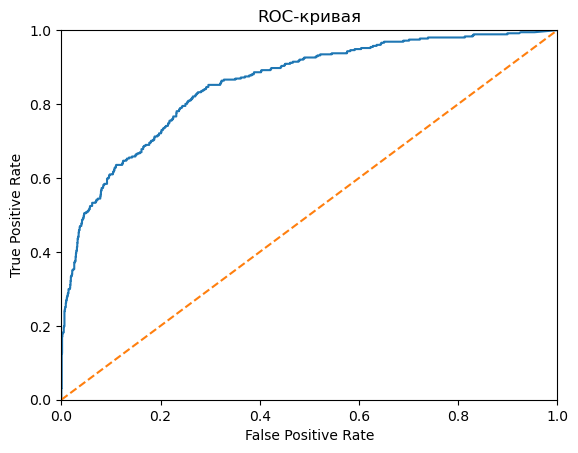

AUC-ROC: 0.8549939060838243


In [26]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)# < напишите код здесь >

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print("AUC-ROC:", roc_auc_score(target_valid, probabilities_one_valid))

Посчитаем точность и полноту

In [27]:
print("Точность:", precision_score(target_test, model.predict(features_test)))
print("Полнота:", recall_score(target_test, model.predict(features_test)))

Точность: 0.5658198614318707
Полнота: 0.649867374005305


## Общий вывод

В результате проведённой работы была построена модель, которая прогнозирует уход клиентов из банка. Было проведено сравнение трёх моделей, в результате которого была выбрана модель случайного леса. Для достижения баланса классов в обучающей выборке было проведено увеличение положительного класса. В результате удалось достичь значений f1 = 0.60, auc-roc = 0.85 и recall = 0.65